# Support Vector Machines Lab

In this lab we will explore several datasets with SVMs. The assets folder contains several datasets (in order of complexity):

1. Breast cancer
- Spambase
- Car evaluation
- Mushroom

For each of these a `.names` file is provided with details on the origin of data.

In [236]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm, cross_validation, metrics, feature_selection, learning_curve

import matplotlib.pyplot as plt
%matplotlib inline

# Exercise 1: Breast Cancer



## 1.a: Load the Data
Use `pandas.read_csv` to load the data and assess the following:
- Are there any missing values? (how are they encoded? do we impute them?)
- Are the features categorical or numerical?
- Are the values normalized?
- How many classes are there in the target?

Perform what's necessary to get to a point where you have a feature matrix `X` and a target vector `y`, both with only numerical entries.

In [57]:
assets_filepath = "../../assets/datasets/"
breast_cancer_data = pd.read_csv("{}breast_cancer.csv".format(assets_filepath))
# spambase_data = pd.read_csv("{}spambase.csv".format(assets_filepath))
# car_data = pd.read_csv("{}car.csv".format(assets_filepath))

In [58]:
# Check if there are any null values
print("Null values in breast_cancer_data?", ("No.", "Yes.") [breast_cancer_data.isnull().values.any()])

# Checking in all features are numerical
print(breast_cancer_data.info())

# Bare_Nuclei is not numeric. Why?
breast_cancer_data['Bare_Nuclei'].sort_values().unique()
print("There are {} ?s in Bare_Nuclei out of {} observations.".format((breast_cancer_data['Bare_Nuclei'] == '?').sum(), breast_cancer_data.shape[0]))

Null values in breast_cancer_data? No.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
Sample_code_number             699 non-null int64
Clump_Thickness                699 non-null int64
Uniformity_of_Cell_Size        699 non-null int64
Uniformity_of_Cell_Shape       699 non-null int64
Marginal_Adhesion              699 non-null int64
Single_Epithelial_Cell_Size    699 non-null int64
Bare_Nuclei                    699 non-null object
Bland_Chromatin                699 non-null int64
Normal_Nucleoli                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB
None
There are 16 ?s in Bare_Nuclei out of 699 observations.


In [112]:
# Drop these values df = df.drop(df[<some boolean condition>].index)
cleaned_breast_cancer_data = breast_cancer_data.drop(breast_cancer_data[breast_cancer_data['Bare_Nuclei'] == '?'].index)

In [120]:
cleaned_breast_cancer_data = cleaned_breast_cancer_data.astype(float)#apply(pd.to_numeric, errors = 'coerce')

In [121]:
# Class:(2 for benign, 4 for malignant)
# INSTEAD y = cleaned_breast_cancer_data['Class'] == 4
cleaned_breast_cancer_data['Class'] = cleaned_breast_cancer_data['Class'].apply(lambda x: (-1,1)[x == 4 or x == 1])

## 1.b: Model Building

- What's the baseline for the accuracy?
- Initialize and train a linear svm. What's the average accuracy score with a 3-fold cross validation?
- Repeat using an rbf classifier. Compare the scores. Which one is better?
- Are your features normalized? if not, try normalizing and repeat the test. Does the score improve?
- What's the best model?
- Print a confusion matrix and classification report for your best model using:
        train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

**Check** to decide which model is best, look at the average cross validation score. Are the scores significantly different from one another?

In [122]:
# Class:(-1 for benign, 1 for malignant)
print("Baseline model accuracy: guessing 'benign' is accurate {}% of the time".format(
        100* round(((cleaned_breast_cancer_data['Class'] + 1) / 2).mean(), 3))
     )

Baseline model accuracy: guessing 'benign' is accurate 35.0% of the time


In [126]:
X = cleaned_breast_cancer_data.drop(labels = ['Class'], axis = 1).apply(preprocessing.scale)
y = cleaned_breast_cancer_data['Class']

In [214]:
linear_svm_model = svm.SVC(kernel = 'linear')
linear_svm_model_scores = cross_validation.cross_val_score(linear_svm_model, X, y = y, cv = 3)

linear_svm_model_con_matrix = metrics.confusion_matrix(y, linear_svm_model.fit(X, y).predict(X))

print(accuracy)
linear_svm_model_con_matrix

Linear kernel accuracy: 0.96 (+/- 0.06)


array([[433,  11],
       [  8, 231]])

In [157]:
rbf_svm_model = svm.SVC(kernel = 'rbf')
rbf_svm_model_scores = cross_validation.cross_val_score(rbf_svm_model, X, y = y, cv = 3)

rbf_svm_model_accuracy = "Linear kernel accuracy: %0.2f (+/- %0.2f)" % (rbf_svm_model_scores.mean(), rbf_svm_model_scores.std() * 2)
rbf_svm_model_con_matrix = metrics.confusion_matrix(y, rbf_svm_model.fit(X, y).predict(X))

print(accuracy)
rbf_svm_model_con_matrix

Linear kernel accuracy: 0.96 (+/- 0.06)


array([[433,  11],
       [  6, 233]])

In [175]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, stratify=y, test_size=0.33, random_state=40)
split_svm_model = svm.SVC(kernel = 'rbf')
split_svm_model.fit(X_train, y_train)
split_svm_model_predictions = split_svm_model.predict(X_test)

split_svm_model_con_matrix = metrics.confusion_matrix(y_test, split_svm_model_predictions)

print(split_svm_model_con_matrix)
print(metrics.classification_report(y_test, split_svm_model_predictions, target_names = ['benign', 'malignant']))

[[141   6]
 [  3  76]]
             precision    recall  f1-score   support

     benign       0.98      0.96      0.97       147
  malignant       0.93      0.96      0.94        79

avg / total       0.96      0.96      0.96       226



**Check:** Are there more false positives or false negatives? Is this good or bad?

## 1.c: Feature Selection

Use any of the strategies offered by `sklearn` to select the most important features.

Repeat the cross validation with only those 5 features. Does the score change?

In [199]:
feature_selector = feature_selection.RFE(estimator = linear_svm_model)
feature_selector.fit_transform(X, y)

best_columns = feature_selector.get_support()
best_columns_names = X.columns[best_columns]
print(best_columns_names)

Index(['Clump_Thickness', 'Uniformity_of_Cell_Shape', 'Marginal_Adhesion',
       'Bare_Nuclei', 'Bland_Chromatin'],
      dtype='object')


In [218]:
selected_linear_svm_model = SVC(kernel = 'linear')

selected_linear_svm_model.fit(X_train[best_columns_names], y_train)
selected_linear_svm_model_predictions = selected_linear_svm_model.predict(X_test[best_columns_names])

selected_linear_svm_model_con_matrix = metrics.confusion_matrix(y_test, linear_svm_model_predictions)

print(selected_linear_svm_model_con_matrix)
print(metrics.classification_report(y_test, selected_linear_svm_model_predictions, target_names = ['benign', 'malignant']))

[[140   7]
 [  3  76]]
             precision    recall  f1-score   support

     benign       0.98      0.95      0.97       147
  malignant       0.92      0.96      0.94        79

avg / total       0.96      0.96      0.96       226



## 1.d: Learning Curves

Learning curves are useful to study the behavior of training and test errors as a function of the number of datapoints available.

- Plot learning curves for train sizes between 10% and 100% (use StratifiedKFold with 5 folds as cross validation)
- What can you say about the dataset? do you need more data or do you need a better model?

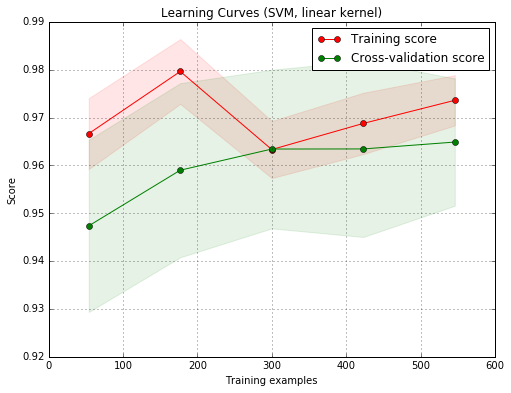

In [243]:
train_sizes_abs, train_scores, test_scores = learning_curve.learning_curve(linear_svm_model, X, y, cv = 5)

plt.figure(figsize = (8,6))
plt.title("Learning Curves (SVM, linear kernel)")

plt.xlabel("Training examples")
plt.ylabel("Score")

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)
plt.grid()

plt.fill_between(train_sizes_abs, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1,
                 color="r")
plt.fill_between(train_sizes_abs, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color="r",
         label="Training score")
plt.plot(train_sizes_abs, test_scores_mean, 'o-', color="g",
         label="Cross-validation score")

plt.legend(loc="best")
plt.show()

##  1.e: Grid Ssearch

Use the grid_search function to explore different kernels and values for the C parameter.

- Can you improve on your best previous score?
- Print the best parameters and the best score

In [245]:
from sklearn import grid_search

In [ ]:
gs = grid_search.GridSearchCV(estimator = linear_svm_model, param_grid = {
        c_vals = 
    })

# Exercise 2
Now that you've completed steps 1.a through 1.e it's time to tackle some harder datasets. But before we do that, let's encapsulate a few things into functions so that it's easier to repeat the analysis.

## 2.a: Cross Validation
Implement a function `do_cv(model, X, y, cv)` that does the following:
- Calculates the cross validation scores
- Prints the model
- Prints and returns the mean and the standard deviation of the cross validation scores

> Answer: see above

## 2.b: Confusion Matrix and Classification report
Implement a function `do_cm_cr(model, X, y, names)` that automates the following:
- Split the data using `train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)`
- Fit the model
- Prints confusion matrix and classification report in a nice format

**Hint:** names is the list of target classes

> Answer: see above

## 2.c: Learning Curves
Implement a function `do_learning_curve(model, X, y, sizes)` that automates drawing the learning curves:
- Allow for sizes input
- Use 5-fold StratifiedKFold cross validation

> Answer: see above

## 2.d: Grid Search
Implement a function `do_grid_search(model, parameters)` that automates the grid search by doing:
- Calculate grid search
- Print best parameters
- Print best score
- Return best estimator


> Answer: see above

# Exercise 3
Using the functions above, analyze the Spambase dataset.

Notice that now you have many more features. Focus your attention on step C => feature selection

- Load the data and get to X, y
- Select the 15 best features
- Perform grid search to determine best model
- Display learning curves

# Exercise 4
Repeat steps 1.a - 1.e for the car dataset. Notice that now features are categorical, not numerical.
- Find a suitable way to encode them
- How does this change our modeling strategy?

Also notice that the target variable `acceptability` has 4 classes. How do we encode them?


# Bonus
Repeat steps 1.a - 1.e for the mushroom dataset. Notice that now features are categorical, not numerical. This dataset is quite large.
- How does this change our modeling strategy?
- Can we use feature selection to improve this?
